In [1]:
%%capture
%run setup.ipynb

In [2]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# let's standardize the numerical features of the dataframe
for df in dataframes.values():
    df[numerics] = StandardScaler().fit_transform(df[numerics])

In [4]:
dataframes['modena']

,date,TG,TN,TX,HU,PP,QQ,RR,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2
365,2018-01-01,-1.403187,-1.244820,-1.570955,1.493803,-0.255833,-1.160612,0.691696,1.462168,-0.499846,1.060424,1.505756,0.400257,-1.176370,-0.783379,0.088763,0.367068,0.835440
366,2018-01-02,-1.079608,-1.206882,-0.892270,-0.371097,-0.040156,-1.101249,-0.389231,0.270581,-1.504835,-0.172544,0.212586,-0.297442,-0.477532,-1.135529,-0.921185,-0.779272,-0.594431
367,2018-01-03,-1.200632,-1.286974,-1.005001,-0.355611,-0.294470,-1.157708,-0.387265,-0.015901,-0.638901,-0.380410,0.255149,0.324938,-0.537943,-1.358843,-1.280421,-1.222328,0.222638
368,2018-01-04,-1.040117,-1.028431,-0.895721,0.328240,-0.407498,-1.368907,-0.418711,0.587768,-0.221736,1.027229,1.116428,0.451792,-0.387809,-1.169885,-1.021212,-0.978113,0.406479
369,2018-01-05,-1.166236,-1.220933,-1.034909,1.188149,-0.272556,-1.478457,-0.418711,0.872248,-0.534610,1.558354,1.360541,1.950260,-1.447326,-1.367432,-0.170446,-0.122695,0.651600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2020-12-24,-0.591693,-0.251397,-0.954387,1.092784,0.090172,-1.099158,-0.399057,2.823160,-1.002341,0.851768,0.728352,0.638109,-1.092366,-1.556390,1.140658,1.363944,0.345199
1454,2020-12-25,-0.901258,-0.800801,-1.103928,0.633895,-0.288703,-1.258428,0.707419,2.209345,-1.169839,1.559935,0.668263,0.768928,-0.698444,-1.642280,0.255474,0.141537,-0.104189
1455,2020-12-26,-1.210823,-1.119764,-1.378853,-0.476242,0.090172,-1.230896,0.455857,0.176333,-0.800079,-0.454704,-0.309439,-0.543222,-1.007290,-1.676636,-0.795345,-0.831318,0.202212
1456,2020-12-27,-1.538223,-1.667763,-1.661830,-0.366207,-0.264483,-1.156430,-0.222178,0.389126,-0.212255,-0.329036,0.197564,-0.321227,-0.653403,-1.410377,-0.464073,-0.397603,0.733307


Time Series Kmeans requires a 3D array, so let's create a 3D array from all the datasets

In [5]:
provinces = dataframes.keys()

# Prepare input data
X = []

for province in provinces:
    group_data = dataframes[province][numerics].values
    
    # Reshape to (n_samples, n_timestamps, n_features)
    group_data = np.expand_dims(group_data, axis=0)
    X.append(group_data)

# Stack the list of arrays to create a 3D array
X = np.vstack(X)

In [6]:
X

array([[[-1.45509117, -1.17303574, -1.58061639, ..., -0.40012834,
         -0.25413602,  0.17688258],
        [-1.05619013, -1.15517679, -0.77445896, ..., -1.16224413,
         -1.00923283, -0.30335281],
        [-1.23670547, -1.35986778, -1.02100782, ..., -1.45393339,
         -1.3958424 , -0.15169953],
        ...,
        [-1.05492778, -0.97658733, -1.08407846, ..., -0.8159407 ,
         -0.66339849,  0.75822016],
        [-1.54724236, -1.28293694, -1.69185006, ..., -0.55279974,
         -0.47915487,  0.96042453],
        [-1.4980109 , -1.29530083, -1.80767069, ..., -0.71540099,
         -0.67699023, -0.07587289]],

       [[-1.44752726, -1.19055732, -1.52735846, ..., -0.24403597,
         -0.04061842,  0.72113744],
        [-1.06436597, -1.15159087, -0.8008914 , ..., -1.11890472,
         -1.04267563, -0.63278295],
        [-1.20532832, -1.31580663, -0.9535883 , ..., -1.43973106,
         -1.44164285, -0.14044827],
        ...,
        [-0.99772922, -0.97345851, -1.19651518, ..., -

Now we have to choose the optimal number of clusters. To do this, we'll run kmeans different times for different cluster sizes.
Each time we'll save the total inertia, which is a measure of goodness of fit for clustering. It represents the sum of squared distances of all observations from the respective cluster. The lower the inertia, the more the clusters are concentrated around the centroids. For time series data, the best choice is to use Dinamic Time Warping (dtw) as metric for clustering, since Euclidean distance might introduce distortions with time series data.

In [17]:
inertia = []
K = list(range(2, 9))

# estimation time: ~m
for k in K:
    km = TimeSeriesKMeans(n_clusters=k, n_init=5, metric='dtw', random_state=0)
    
    km = km.fit(X)
    
    inertia.append(km.inertia_)

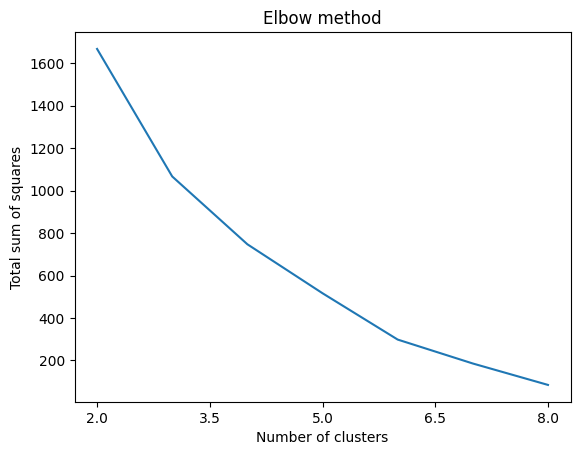

In [18]:
plt.plot(K, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Total sum of squares')
plt.title('Elbow method')

x_ticks = np.linspace(min(K), max(K), 5)

# Set the ticks on the x-axis
plt.xticks(x_ticks)

plt.show()